# US Adult Income Dataset Feature Significance Analysis



## Data Preprocessing

In [22]:
import csv
import time
import sklearn
import datetime
import pandas as pd
import itertools

# pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 60

In [25]:
from sklearn.model_selection import cross_val_score

We use `sklearn == '0.23.2'`

In [2]:
sklearn.__version__

'0.23.2'

Prepare the complete dataset by concat the training and test dataset.

In [3]:
train = pd.read_csv("adult-training.csv", sep=', ', engine='python',)
test = pd.read_csv("adult-test.csv", sep=', ', engine='python',)
complete_data = pd.concat([train, test], ignore_index=True)

## Feature selection

We list all the columns, and comment them if we choose to not use them in our analysis.

In [7]:
# feature_cols = train.columns
all_feature_cols = [
    'age',
#     'workclass', 
    'education_num',
#     'marital_status', 
#     'occupation', 
#     'relationship', 
    'race', 
    'gender',
#     'capital_gain', 
#     'capital_loss', 
    'hours_per_week', 
    'native_country',
    'income_bracket'
]

all_continuous_cols = [
    'age',
    'fnlwgt',
    'education_num',
#     'capital_gain', 
#     'capital_loss', 
    'hours_per_week', 
    'income_bracket',
]

# categorical_cols = list(set(feature_cols) - set(continuous_cols))
all_categorical_cols = [
#     'marital_status',
#     'relationship',
#     'occupation',
    'native_country',
    'race',
    'workclass',
    'gender',
    "income_bracket"
]

all_education_cols = ['education', 'education_num']

In [8]:
continuous_cols = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain', 
    'capital_loss', 
    'hours_per_week', 
]
continuous_cols = list(set(continuous_cols) & set(all_continuous_cols))

categorical_cols = [
    'marital_status',
    'occupation',
    'native_country', # We don't care about the native country in the sense that we take into consideration the race
    'race',
    'workclass',
    'gender',
    'income_bracket',
]
categorical_cols = list(set(categorical_cols) & set(all_categorical_cols))

target_col = "income_bracket"
weight_col = "fnlwgt"

feature_space = continuous_cols + categorical_cols

# education_cols = ['education', 'education_num']

In [9]:
backup_train = train
train = train[feature_space]

train.head()

,education_num,age,hours_per_week,fnlwgt,workclass,native_country,gender,race,income_bracket
0,13,39,40,77516,State-gov,United-States,Male,White,<=50K
1,13,50,13,83311,Self-emp-not-inc,United-States,Male,White,<=50K
2,9,38,40,215646,Private,United-States,Male,White,<=50K
3,7,53,40,234721,Private,United-States,Male,Black,<=50K
4,13,28,40,338409,Private,Cuba,Female,Black,<=50K


## One-Hot-Encoding

- `marital_status` (`bool`): 2 classes, with one containing "Divorced" and "Never-married", and the rest.
- `occupation` (`expanded`) : flat that out to all classes.
- `native_country` (`bool`) : United-States or foreign
- `race`: 5 classes
- `workclass`: 
  - `'State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?' 'Self-emp-inc''Without-pay' 'Never-worked'`
- `gender` (`bool`): 2
- `income_bracket`: expanded.

In [10]:
for c in categorical_cols:
    t = train[c].unique()
    print(c, t)
    print()

workclass ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

native_country ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands']

gender ['Male' 'Female']

race ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

income_bracket ['<=50K' '>50K']



In [11]:
def cat_encoder(data, col_name) -> dict:
    """Expand a category column into a one-hot encoded column."""
    col = data[col_name]
    cates = col.unique()

    result = {}
    for i in cates:
        name = f"{col_name}-{i}"
        new_col = col.apply(
            lambda x: 1 if i.casefold() == x.casefold() else 0
        )
        new_col.name = name
        result[name] = new_col
    return result

In [12]:
def bool_encoder(data, col_name, true_value) -> dict:
    """Make a column into a boolean column."""
    col = data[col_name]
    cates = col.unique()
    
    foo = true_value
    if not callable(foo):
    
        if not isinstance(true_value, list):
            true_value = [true_value]

        if not (set(true_value) & set(cates)):
            raise ValueError(f"No such value: {true_value} in {cates}")
        
        foo = (lambda x: 1 if x in true_value else 0)
        
    new_col = col.apply(foo)
    result = {col_name: new_col}
    return result

In [13]:
def encode_dataset(data) -> dict:
    train = data.copy()
    
    boolean_classes = {
        "income_bracket": [">50K", ">50K."],
        "native_country": "United-States",
        "gender": "Male",
    }
    
    result = {}
    
    for c in categorical_cols:
        if c not in boolean_classes:
            result[c] = cat_encoder(train, c) 
    
    for c, v in boolean_classes.items():
        result[c] = bool_encoder(data, c, v)

    return result

In [14]:
def data_wrangling(dataset):
    dataset = dataset[feature_space]
    new_cols = encode_dataset(dataset)
    old_cols = list(new_cols.keys())
    new_columns = pd.concat([c for cs in new_cols.values() for c in cs.values()], axis=1)
    data = pd.concat([dataset.drop(old_cols, axis=1), new_columns], axis=1)
    return data

### Data wrangling

In [16]:
training = data_wrangling(train)
testing = data_wrangling(test)

## Method 1: Logistic Regression

In [23]:
def get_XWy(data):
    y = data[target_col]
    W = data[weight_col]
    X = data.drop([target_col, weight_col], axis=1)
    return X,W,y

In [24]:
def get_param_dict(**kwargs): return kwargs

In [99]:
data = data_wrangling(complete_data)
X,W,y = get_XWy(data)

In [100]:
params = get_param_dict(    
    penalty='l2', dual=False, tol=1e-5, C=1.0, 
    fit_intercept=True, intercept_scaling=1, 
    class_weight=None, 
    random_state=None, solver='lbfgs', 
    max_iter=100000, 
    multi_class='auto', 
    verbose=3, 
    warm_start=False, 
    n_jobs=None,
    l1_ratio=None
)

In [101]:
from sklearn.utils import parallel_backend
from sklearn.model_selection import learning_curve

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
regressor = LogisticRegression(**params)
st = time.time()
with parallel_backend('threading'):
    scores = cross_val_score(regressor, X, y, fit_params={'sample_weight': W})
ed = time.time()
print(f"{ed - st} s")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.7s finished


11.716801166534424 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.6s finished


In [104]:
regressor.fit(X, y, sample_weight=W)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished


LogisticRegression(max_iter=100000, tol=1e-05, verbose=3)

In [105]:
results = []

In [106]:
for max_iter in range(100, 1000, 50):
    regressor = LogisticRegression(
        penalty='l2', dual=False, tol=1e-7, C=1.0, 
        fit_intercept=True, intercept_scaling=1, 
        class_weight=None, 
        random_state=None, solver='lbfgs', 
        max_iter=max_iter, 
        multi_class='auto', 
        verbose=3, 
        warm_start=False, 
        n_jobs=None,
        l1_ratio=None
    )
    st = time.time()
    #     with parallel_backend('threading'):
    #         scores = cross_val_score(regressor, X, y, fit_params={'sample_weight': W})
    regressor.fit(X, y, sample_weight=W)
    score = regressor.score(X, y, sample_weight=W)
    ed = time.time()
    print(f"{ed - st} s")
    coef = regressor.coef_
    
    results.append({
        "max_iter": max_iter, 
        "regressor": regressor, 
        "time" : ed - st, 
        "coef": coef
    })

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.4642300605773926 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.6331279277801514 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8154802322387695 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.9685912132263184 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.124964714050293 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.3111929893493652 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.4955370426177979 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.6942658424377441 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1.8622372150421143 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2.0535809993743896 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2.2190139293670654 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2.6126468181610107 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3.1442911624908447 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3.95159912109375 s


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


4.753476858139038 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5.160799026489258 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5.642211675643921 s
5.853416204452515 s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


In [107]:
df_col_names = [i["max_iter"] for i in results]
df_coefs = [i["coef"][0] for i in results]

In [108]:
coef_changes = pd.DataFrame(df_coefs).T.rename(columns={
    i: v for i, v in enumerate(df_col_names)
}).T.rename(columns={
    i: v for i, v in enumerate(X.columns)
}).T

In [110]:
now_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
fname = f"{now_str}_logistic_coef_changes.csv"
coef_changes.to_csv(fname)

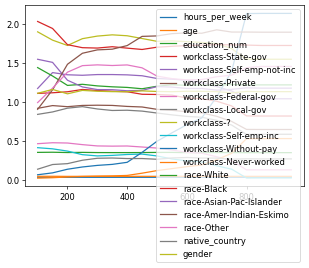

In [111]:
p = abs(coef_changes[df_col_names[:]]).T.plot()

<AxesSubplot:>

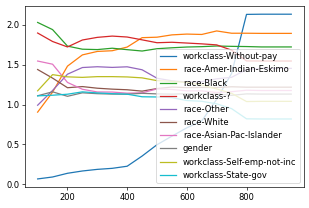

In [112]:
abs(coef_changes).sort_values(by=df_col_names[-1], ascending=False)[:10].T.plot()

<AxesSubplot:>

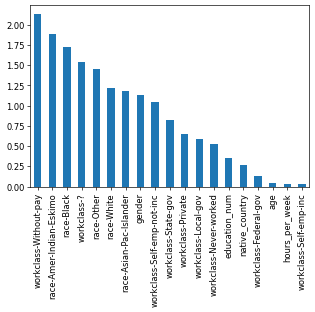

In [113]:
abs(coef_changes).sort_values(by=df_col_names[-1], ascending=False)[df_col_names[-1]].plot(kind='bar')

In [78]:
coef = regressor.coef_
coef.shape, X.shape

((1, 19), (48842, 19))

In [79]:
feature_coef = pd.DataFrame(coef, columns=X.columns).T
# feature_coef.sort_values(by=0, ascending=False)

<AxesSubplot:>

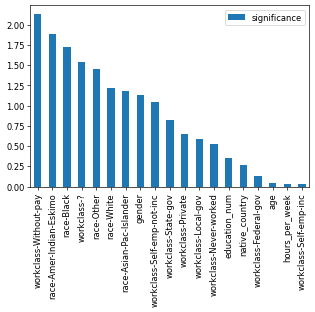

In [80]:
significance = abs(feature_coef)
significance = significance.sort_values(by=0, ascending=False)
significance = significance.rename(columns={0: "significance"});
significance.plot(kind='bar')

In [ ]:
cross_val_scores = {}

In [116]:
for max_iter in [100000]:
    regressor = LogisticRegression(
        penalty='l2', dual=False, tol=1e-7, C=1.0, 
        fit_intercept=True, intercept_scaling=1, 
        class_weight=None, 
        random_state=None, solver='lbfgs', 
        max_iter=max_iter, 
        multi_class='auto', 
        verbose=3, 
        warm_start=False, 
        n_jobs=None,
        l1_ratio=None
    )
    with parallel_backend('threading'):
        scores = cross_val_score(regressor, X, y, fit_params={'sample_weight': W})
    cross_val_scores[max_iter] = scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s fini

In [129]:
cross_val_scores_df = pd.DataFrame(
    [[k, sum(v) / len(v)] for k, v in cross_val_scores.items()],
    columns=['Iteration', 'Avg score']
)

In [130]:
cross_val_scores_df

,Iteration,Avg score
0,100,0.802813
1,300,0.803960
2,500,0.803837
3,700,0.803673
4,1000,0.803755
5,10000,0.803755
6,100000,0.803755


## Train with Random Forest


In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [136]:
regressor = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    bootstrap=True,
    oob_score=False,
    n_jobs=None, 
    random_state=None, verbose=1, 
    warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [137]:
r = regressor.fit(X, y, sample_weight=W)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


In [138]:
r = tree.DecisionTreeClassifier().fit(X, y)

In [139]:
fi = r.feature_importances_

In [140]:
fi.T

array([1.78940319e-01, 3.54069796e-01, 2.42036341e-01, 9.57249137e-03,
       1.70110723e-02, 2.13629209e-02, 9.38585513e-03, 1.41306187e-02,
       9.11673938e-03, 1.31105256e-02, 2.57254642e-04, 0.00000000e+00,
       1.57107008e-02, 1.03008460e-02, 8.14603790e-03, 2.70287935e-03,
       2.68870717e-03, 2.65931189e-02, 6.48637756e-02])

In [158]:
feature_importance = pd.DataFrame(fi).rename({i: v for i,v in enumerate(X.columns)})
now_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
fname = f"{now_str}_random_forest_feature_importance.csv"

In [159]:
feature_importance.T.to_csv(fname, index=False)

In [143]:
cross_val_score(regressor, X, y, fit_params={'sample_weight': W})

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

array([0.78749104, 0.78605794, 0.78941441, 0.78439803, 0.7779484 ])

In [153]:
from IPython.display import Image

In [161]:
sklearn.tree.export_graphviz(
    r, max_depth=3, out_file="tree.dot",
    feature_names=X.columns
)

In [162]:
! dot -Tpng tree.dot -o tree.png # Output the dot file to image

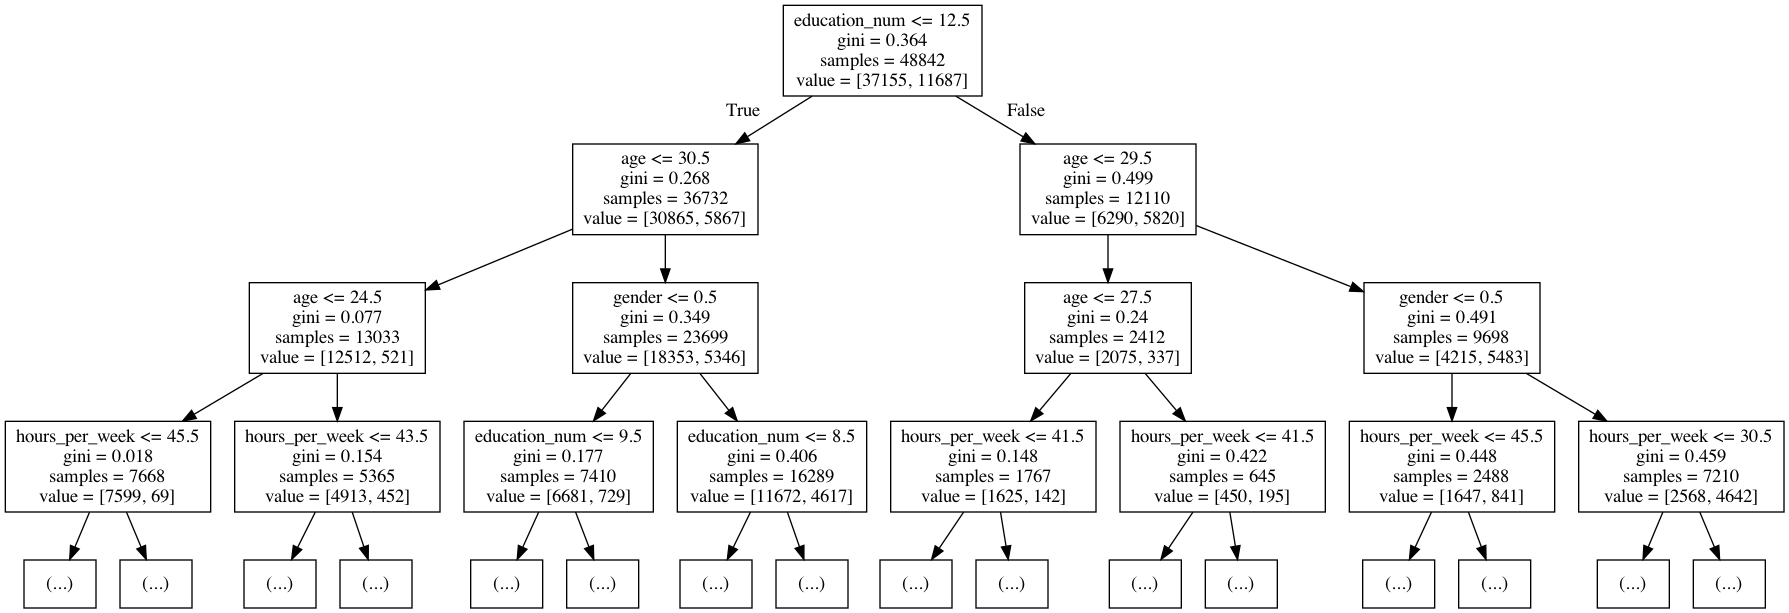

In [163]:
Image("tree.png")

In [160]:
feature_importance.sort_values(by=0, ascending=False)

,0
age,0.354070
education_num,0.242036
hours_per_week,0.178940
gender,0.064864
native_country,0.026593
workclass-Private,0.021363
workclass-Self-emp-not-inc,0.017011
race-White,0.015711
workclass-Local-gov,0.014131
workclass-Self-emp-inc,0.013111


In [165]:
rf_cross_va_result = {}

In [173]:

# for n_estimators in [100, 1000, 10000]:
n_estimators = 100
max_depth = 10
regressor = RandomForestClassifier(
    n_estimators=n_estimators, 
    criterion='gini', 
    max_depth=max_depth, 
    min_samples_split=2,
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, 
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    min_impurity_split=None, 
    bootstrap=True,
    oob_score=False,
    n_jobs=None, 
    random_state=None, verbose=1, 
    warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

scores = cross_val_score(regressor, X, y, fit_params={'sample_weight': W})
rf_cross_va_result[n_estimators] = scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [167]:
rf_cross_va_result

{100: array([0.7882076 , 0.78564848, 0.78880016, 0.78644554, 0.77856265]),
 1000: array([0.78953834, 0.78656976, 0.79084767, 0.78552416, 0.7787674 ])}

In [170]:
import xgboost

In [172]:
xgboost.train({
    'max_depth' = 4
}, )

<function xgboost.training.train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None)>

## Naive Baysian

In [284]:
from sklearn.naive_bayes import CategoricalNB

regressor = CategoricalNB(alpha=1.0, fit_prior=True, class_prior=None)
regressor.fit(X, y, sample_weight=W)
regressor.score(X, y, sample_weight=W)
len(regressor.feature_log_prob_) ==  len(X.columns)
regressor

## Neural Network (Multi-layer proceptron)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
regressor = MLPClassifier(
    solver='lbfgs', 
    alpha=1e-5,
    hidden_layer_sizes=(24, 10), 
    random_state=1,
    max_iter=500
)

In [ ]:
regressor.fit(X, y)
regressor.score(X, y, sample_weight=W)
cross_val_score(regressor, X, y, fit_params={'sample_weight': W})